# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

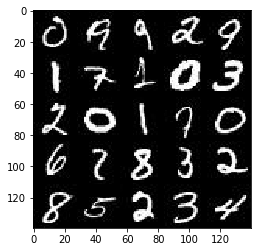

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

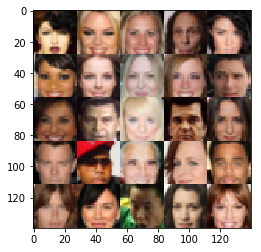

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    
    z_inputs = tf.placeholder(tf.float32, (None, z_dim))
    
    learning_rate = tf.placeholder(tf.float32)

    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


In [6]:
def lrelu(x, alpha):
    return tf.maximum(x * alpha, x)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha = 0.2, keep_prob = 0.5):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    kernel_initializer = tf.contrib.layers.xavier_initializer();
    
    with tf.variable_scope('discriminator', reuse = reuse):
        
        l1 = tf.layers.conv2d(images, 64, kernel_size = 5, strides = 2, padding = 'same', kernel_initializer = kernel_initializer)
        lrelu1 = lrelu(l1, alpha)
        #16x16x64
        
        l2 = tf.layers.conv2d(lrelu1, 128, kernel_size = 5, strides = 2, padding = 'same', kernel_initializer = kernel_initializer)
        dropout2 = tf.layers.dropout(l2, keep_prob, training = True)
        bn2 = tf.layers.batch_normalization(dropout2, training = True)
        lrelu2 = lrelu(l2, alpha)
        #8x8x128
        
        l3 = tf.layers.conv2d(lrelu2, 256, kernel_size = 5, strides = 2, padding = 'same', kernel_initializer = kernel_initializer)
        dropout3 = tf.layers.dropout(l3, keep_prob, training = True)
        bn3 = tf.layers.batch_normalization(dropout3, training = True)
        lrelu3 = lrelu(l3, alpha)
        #4x4x256
        
        flat = tf.reshape(lrelu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse = (not is_train)):
    
        l1 = tf.layers.dense(z, 7 * 7 * 256)

        l1 = tf.reshape(l1, (-1, 7, 7, 256))
        b1 = tf.layers.batch_normalization(l1, training = is_train)
        lrelu1 = lrelu(b1, alpha)
        #7x7x256

        l2 = tf.layers.conv2d_transpose(lrelu1, 128, kernel_size = 5, strides = 2, padding = 'same')
        b2 = tf.layers.batch_normalization(l2, training = is_train)
        lrelu2 = lrelu(b2, alpha)
        #14x14x128

        l3 = tf.layers.conv2d_transpose(lrelu2, 64, kernel_size = 5, strides = 2, padding = 'same')
        b3 = tf.layers.batch_normalization(l3, training = is_train)
        lrelu3 = lrelu(b3, alpha)
        #28x28x64

        logits = tf.layers.conv2d_transpose(lrelu3, out_channel_dim, kernel_size = 3, strides = 1, padding = 'same')

        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    generator_model = generator(input_z, out_channel_dim, is_train = True, alpha = alpha)
    
    discriminator_model_real, discriminator_logits_real = discriminator(input_real, alpha = alpha)
    
    discriminator_model_fake, discriminator_logits_fake = discriminator(generator_model, reuse = True, alpha = alpha)
    
    smooth_factor = 0.1
    
    discriminator_real_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_real, labels=tf.ones_like(discriminator_model_real) * (1 - smooth_factor)))
    
    discriminator_fake_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake, labels=tf.zeros_like(discriminator_model_fake)))
    
    generator_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_fake, labels=tf.ones_like(discriminator_model_fake)))

    discriminator_loss = discriminator_real_loss + discriminator_fake_loss
    
    return discriminator_loss, generator_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    treinable_variables = tf.trainable_variables()
    discriminator_variables = [variable for variable in treinable_variables if variable.name.startswith('discriminator')]
    generator_variables = [variable for variable in treinable_variables if variable.name.startswith('generator')]
    
    discriminator_training_optimizer = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = discriminator_variables)
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    generator_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    
    with tf.control_dependencies(generator_updates):
        generator_training_optimizer = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list = generator_variables)
    
    return discriminator_training_optimizer, generator_training_optimizer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, print_every=10, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha=0.2)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.9797... Generator Loss: 0.8144
Epoch 1/2... Discriminator Loss: 0.5311... Generator Loss: 1.7905
Epoch 1/2... Discriminator Loss: 0.5062... Generator Loss: 1.8987
Epoch 1/2... Discriminator Loss: 0.4090... Generator Loss: 3.4959
Epoch 1/2... Discriminator Loss: 0.4013... Generator Loss: 3.7117
Epoch 1/2... Discriminator Loss: 0.4402... Generator Loss: 2.5093
Epoch 1/2... Discriminator Loss: 0.3550... Generator Loss: 4.2279
Epoch 1/2... Discriminator Loss: 0.4121... Generator Loss: 2.9527
Epoch 1/2... Discriminator Loss: 1.3808... Generator Loss: 0.6861
Epoch 1/2... Discriminator Loss: 1.8584... Generator Loss: 0.5303


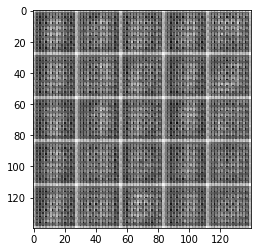

Epoch 1/2... Discriminator Loss: 1.5829... Generator Loss: 0.6877
Epoch 1/2... Discriminator Loss: 1.3682... Generator Loss: 0.7285
Epoch 1/2... Discriminator Loss: 1.2593... Generator Loss: 0.8962
Epoch 1/2... Discriminator Loss: 1.2409... Generator Loss: 0.8551
Epoch 1/2... Discriminator Loss: 1.1385... Generator Loss: 0.9555
Epoch 1/2... Discriminator Loss: 1.3229... Generator Loss: 0.7841
Epoch 1/2... Discriminator Loss: 1.3291... Generator Loss: 0.7204
Epoch 1/2... Discriminator Loss: 1.3698... Generator Loss: 1.0053
Epoch 1/2... Discriminator Loss: 1.2831... Generator Loss: 0.7884
Epoch 1/2... Discriminator Loss: 1.2425... Generator Loss: 1.0286


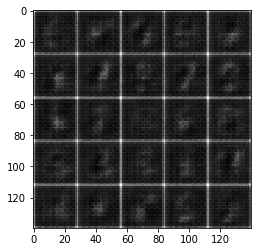

Epoch 1/2... Discriminator Loss: 1.1973... Generator Loss: 0.8124
Epoch 1/2... Discriminator Loss: 1.1980... Generator Loss: 0.9805
Epoch 1/2... Discriminator Loss: 1.4107... Generator Loss: 0.7128
Epoch 1/2... Discriminator Loss: 1.3897... Generator Loss: 0.6662
Epoch 1/2... Discriminator Loss: 1.3479... Generator Loss: 0.9704
Epoch 1/2... Discriminator Loss: 1.3495... Generator Loss: 0.8724
Epoch 1/2... Discriminator Loss: 1.3162... Generator Loss: 0.8934
Epoch 1/2... Discriminator Loss: 1.3259... Generator Loss: 0.7257
Epoch 1/2... Discriminator Loss: 1.2948... Generator Loss: 0.8157
Epoch 1/2... Discriminator Loss: 1.5146... Generator Loss: 0.4757


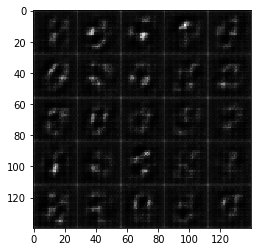

Epoch 1/2... Discriminator Loss: 1.4023... Generator Loss: 0.7735
Epoch 1/2... Discriminator Loss: 1.3724... Generator Loss: 0.8255
Epoch 1/2... Discriminator Loss: 1.4039... Generator Loss: 0.8494
Epoch 1/2... Discriminator Loss: 1.3344... Generator Loss: 0.9161
Epoch 1/2... Discriminator Loss: 1.2516... Generator Loss: 0.7564
Epoch 1/2... Discriminator Loss: 1.3296... Generator Loss: 0.8167
Epoch 1/2... Discriminator Loss: 1.3385... Generator Loss: 0.8216
Epoch 1/2... Discriminator Loss: 1.2993... Generator Loss: 1.0048
Epoch 1/2... Discriminator Loss: 1.3551... Generator Loss: 0.7363
Epoch 1/2... Discriminator Loss: 1.3603... Generator Loss: 0.7224


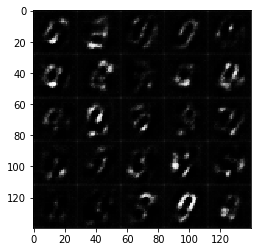

Epoch 1/2... Discriminator Loss: 1.3155... Generator Loss: 0.9624
Epoch 1/2... Discriminator Loss: 1.2747... Generator Loss: 0.9506
Epoch 1/2... Discriminator Loss: 1.2824... Generator Loss: 0.9421
Epoch 1/2... Discriminator Loss: 1.2795... Generator Loss: 0.7685
Epoch 1/2... Discriminator Loss: 1.3031... Generator Loss: 1.1309
Epoch 1/2... Discriminator Loss: 1.3076... Generator Loss: 0.8304
Epoch 1/2... Discriminator Loss: 1.3645... Generator Loss: 0.9105
Epoch 1/2... Discriminator Loss: 1.2475... Generator Loss: 0.8305
Epoch 1/2... Discriminator Loss: 1.2450... Generator Loss: 0.9320
Epoch 1/2... Discriminator Loss: 1.2847... Generator Loss: 0.9592


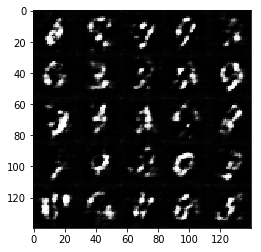

Epoch 1/2... Discriminator Loss: 1.2621... Generator Loss: 0.9139
Epoch 1/2... Discriminator Loss: 1.2451... Generator Loss: 0.7937
Epoch 1/2... Discriminator Loss: 1.2841... Generator Loss: 0.9773
Epoch 1/2... Discriminator Loss: 1.2697... Generator Loss: 0.8895
Epoch 1/2... Discriminator Loss: 1.3636... Generator Loss: 1.3397
Epoch 1/2... Discriminator Loss: 1.2703... Generator Loss: 0.8246
Epoch 1/2... Discriminator Loss: 1.2792... Generator Loss: 0.9256
Epoch 1/2... Discriminator Loss: 1.2734... Generator Loss: 0.7307
Epoch 1/2... Discriminator Loss: 1.2548... Generator Loss: 0.8008
Epoch 1/2... Discriminator Loss: 1.2744... Generator Loss: 1.0012


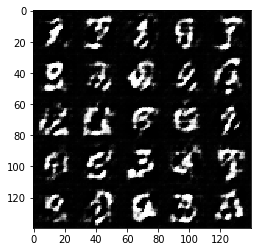

Epoch 1/2... Discriminator Loss: 1.3696... Generator Loss: 1.2979
Epoch 1/2... Discriminator Loss: 1.2480... Generator Loss: 1.0253
Epoch 1/2... Discriminator Loss: 1.3112... Generator Loss: 0.8143
Epoch 1/2... Discriminator Loss: 1.2891... Generator Loss: 0.6758
Epoch 1/2... Discriminator Loss: 1.2900... Generator Loss: 0.8333
Epoch 1/2... Discriminator Loss: 1.4525... Generator Loss: 1.4403
Epoch 1/2... Discriminator Loss: 1.2616... Generator Loss: 0.9928
Epoch 1/2... Discriminator Loss: 1.2827... Generator Loss: 1.0412
Epoch 1/2... Discriminator Loss: 1.3424... Generator Loss: 0.5417
Epoch 1/2... Discriminator Loss: 1.1949... Generator Loss: 1.0554


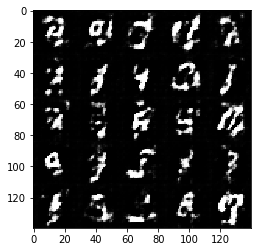

Epoch 1/2... Discriminator Loss: 1.2381... Generator Loss: 1.0984
Epoch 1/2... Discriminator Loss: 1.2390... Generator Loss: 1.0845
Epoch 1/2... Discriminator Loss: 1.2630... Generator Loss: 0.9304
Epoch 1/2... Discriminator Loss: 1.2717... Generator Loss: 0.6965
Epoch 1/2... Discriminator Loss: 1.1986... Generator Loss: 0.7711
Epoch 1/2... Discriminator Loss: 1.2831... Generator Loss: 0.7313
Epoch 1/2... Discriminator Loss: 1.1539... Generator Loss: 1.1701
Epoch 1/2... Discriminator Loss: 1.1666... Generator Loss: 0.7957
Epoch 1/2... Discriminator Loss: 1.1740... Generator Loss: 1.0668
Epoch 1/2... Discriminator Loss: 1.3034... Generator Loss: 1.6057


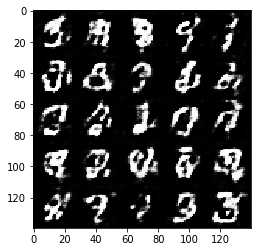

Epoch 1/2... Discriminator Loss: 1.1397... Generator Loss: 1.1382
Epoch 1/2... Discriminator Loss: 1.1966... Generator Loss: 1.2715
Epoch 1/2... Discriminator Loss: 1.1800... Generator Loss: 1.2998
Epoch 1/2... Discriminator Loss: 1.2278... Generator Loss: 0.6647
Epoch 1/2... Discriminator Loss: 1.1520... Generator Loss: 1.1371
Epoch 1/2... Discriminator Loss: 1.1309... Generator Loss: 1.1820
Epoch 1/2... Discriminator Loss: 1.2247... Generator Loss: 0.8197
Epoch 1/2... Discriminator Loss: 1.1540... Generator Loss: 0.8407
Epoch 1/2... Discriminator Loss: 1.1861... Generator Loss: 1.2273
Epoch 1/2... Discriminator Loss: 1.3262... Generator Loss: 0.5390


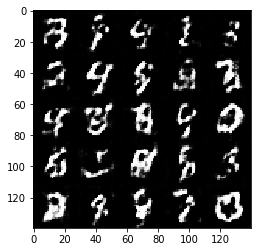

Epoch 1/2... Discriminator Loss: 1.0469... Generator Loss: 1.1189
Epoch 1/2... Discriminator Loss: 1.0634... Generator Loss: 1.2925
Epoch 1/2... Discriminator Loss: 1.0959... Generator Loss: 1.0651
Epoch 2/2... Discriminator Loss: 1.1613... Generator Loss: 0.8086
Epoch 2/2... Discriminator Loss: 1.1369... Generator Loss: 0.9623
Epoch 2/2... Discriminator Loss: 1.0809... Generator Loss: 0.9723
Epoch 2/2... Discriminator Loss: 1.3796... Generator Loss: 0.5107
Epoch 2/2... Discriminator Loss: 1.1037... Generator Loss: 0.9463
Epoch 2/2... Discriminator Loss: 1.2333... Generator Loss: 0.9937
Epoch 2/2... Discriminator Loss: 1.3101... Generator Loss: 0.6141


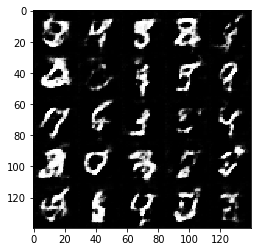

Epoch 2/2... Discriminator Loss: 1.2549... Generator Loss: 0.6496
Epoch 2/2... Discriminator Loss: 1.0968... Generator Loss: 1.0698
Epoch 2/2... Discriminator Loss: 1.1188... Generator Loss: 1.1495
Epoch 2/2... Discriminator Loss: 1.1438... Generator Loss: 1.0141
Epoch 2/2... Discriminator Loss: 1.1960... Generator Loss: 0.7259
Epoch 2/2... Discriminator Loss: 1.1030... Generator Loss: 1.1211
Epoch 2/2... Discriminator Loss: 1.1587... Generator Loss: 1.3082
Epoch 2/2... Discriminator Loss: 1.2727... Generator Loss: 1.0098
Epoch 2/2... Discriminator Loss: 1.1885... Generator Loss: 1.0533
Epoch 2/2... Discriminator Loss: 1.1989... Generator Loss: 1.0172


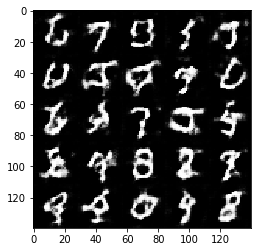

Epoch 2/2... Discriminator Loss: 1.2392... Generator Loss: 1.1666
Epoch 2/2... Discriminator Loss: 1.3249... Generator Loss: 0.8627
Epoch 2/2... Discriminator Loss: 1.2945... Generator Loss: 1.1500
Epoch 2/2... Discriminator Loss: 1.3182... Generator Loss: 1.0399
Epoch 2/2... Discriminator Loss: 1.2805... Generator Loss: 0.9537
Epoch 2/2... Discriminator Loss: 1.2714... Generator Loss: 0.9729
Epoch 2/2... Discriminator Loss: 1.3005... Generator Loss: 1.0010
Epoch 2/2... Discriminator Loss: 1.4012... Generator Loss: 0.9698
Epoch 2/2... Discriminator Loss: 1.3530... Generator Loss: 0.8703
Epoch 2/2... Discriminator Loss: 1.3201... Generator Loss: 0.8732


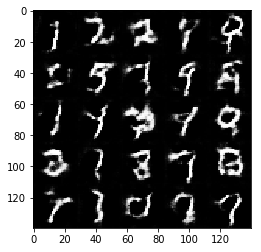

Epoch 2/2... Discriminator Loss: 1.3336... Generator Loss: 0.7575
Epoch 2/2... Discriminator Loss: 1.3074... Generator Loss: 0.7767
Epoch 2/2... Discriminator Loss: 1.2534... Generator Loss: 0.7562
Epoch 2/2... Discriminator Loss: 1.3240... Generator Loss: 0.8706
Epoch 2/2... Discriminator Loss: 1.3402... Generator Loss: 0.7064
Epoch 2/2... Discriminator Loss: 1.4929... Generator Loss: 1.4102
Epoch 2/2... Discriminator Loss: 1.2455... Generator Loss: 0.8905
Epoch 2/2... Discriminator Loss: 1.2855... Generator Loss: 0.7955
Epoch 2/2... Discriminator Loss: 1.2462... Generator Loss: 0.7768
Epoch 2/2... Discriminator Loss: 1.2557... Generator Loss: 0.9527


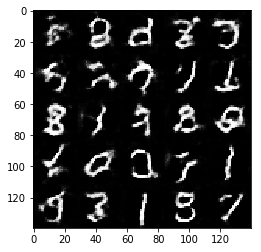

Epoch 2/2... Discriminator Loss: 1.2860... Generator Loss: 0.9875
Epoch 2/2... Discriminator Loss: 1.3064... Generator Loss: 0.6862
Epoch 2/2... Discriminator Loss: 1.3131... Generator Loss: 0.8301
Epoch 2/2... Discriminator Loss: 1.2998... Generator Loss: 0.8244
Epoch 2/2... Discriminator Loss: 1.2522... Generator Loss: 0.8263
Epoch 2/2... Discriminator Loss: 1.4278... Generator Loss: 1.5704
Epoch 2/2... Discriminator Loss: 1.2999... Generator Loss: 1.0681
Epoch 2/2... Discriminator Loss: 1.2380... Generator Loss: 0.9072
Epoch 2/2... Discriminator Loss: 1.2667... Generator Loss: 0.8802
Epoch 2/2... Discriminator Loss: 1.2705... Generator Loss: 0.8542


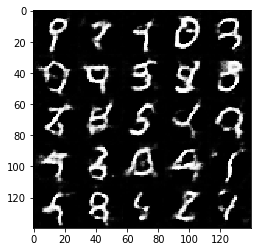

Epoch 2/2... Discriminator Loss: 1.2680... Generator Loss: 0.7737
Epoch 2/2... Discriminator Loss: 1.2963... Generator Loss: 0.9041
Epoch 2/2... Discriminator Loss: 1.3053... Generator Loss: 0.8186
Epoch 2/2... Discriminator Loss: 1.3384... Generator Loss: 0.6803
Epoch 2/2... Discriminator Loss: 1.2745... Generator Loss: 0.7765
Epoch 2/2... Discriminator Loss: 1.2315... Generator Loss: 1.0306
Epoch 2/2... Discriminator Loss: 1.2575... Generator Loss: 1.0221
Epoch 2/2... Discriminator Loss: 1.2488... Generator Loss: 0.8822
Epoch 2/2... Discriminator Loss: 1.2928... Generator Loss: 0.6725
Epoch 2/2... Discriminator Loss: 1.1950... Generator Loss: 0.9428


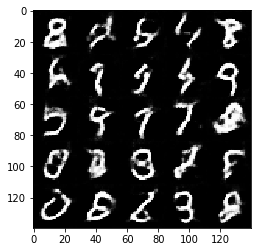

Epoch 2/2... Discriminator Loss: 1.2625... Generator Loss: 0.7762
Epoch 2/2... Discriminator Loss: 1.2700... Generator Loss: 0.8524
Epoch 2/2... Discriminator Loss: 1.2296... Generator Loss: 0.9712
Epoch 2/2... Discriminator Loss: 1.3014... Generator Loss: 1.0340
Epoch 2/2... Discriminator Loss: 1.3246... Generator Loss: 0.7909
Epoch 2/2... Discriminator Loss: 1.2493... Generator Loss: 0.9998
Epoch 2/2... Discriminator Loss: 1.3549... Generator Loss: 1.1871
Epoch 2/2... Discriminator Loss: 1.3147... Generator Loss: 1.0208
Epoch 2/2... Discriminator Loss: 1.2261... Generator Loss: 1.0565
Epoch 2/2... Discriminator Loss: 1.2716... Generator Loss: 0.9530


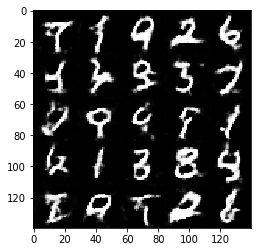

Epoch 2/2... Discriminator Loss: 1.3027... Generator Loss: 0.6950
Epoch 2/2... Discriminator Loss: 1.2486... Generator Loss: 0.7715
Epoch 2/2... Discriminator Loss: 1.1989... Generator Loss: 0.8407
Epoch 2/2... Discriminator Loss: 1.2779... Generator Loss: 0.8710
Epoch 2/2... Discriminator Loss: 1.2709... Generator Loss: 0.7173
Epoch 2/2... Discriminator Loss: 1.3219... Generator Loss: 0.8885
Epoch 2/2... Discriminator Loss: 1.2562... Generator Loss: 0.8766
Epoch 2/2... Discriminator Loss: 1.3004... Generator Loss: 1.0751
Epoch 2/2... Discriminator Loss: 1.2983... Generator Loss: 1.0852
Epoch 2/2... Discriminator Loss: 1.2853... Generator Loss: 0.8010


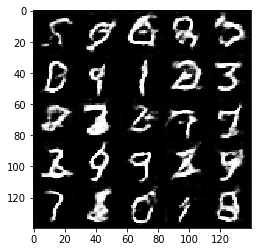

Epoch 2/2... Discriminator Loss: 1.2593... Generator Loss: 1.0775
Epoch 2/2... Discriminator Loss: 1.2767... Generator Loss: 0.7916
Epoch 2/2... Discriminator Loss: 1.2537... Generator Loss: 0.7405
Epoch 2/2... Discriminator Loss: 1.3316... Generator Loss: 0.7898
Epoch 2/2... Discriminator Loss: 1.3193... Generator Loss: 0.7513
Epoch 2/2... Discriminator Loss: 1.2753... Generator Loss: 0.9210
Epoch 2/2... Discriminator Loss: 1.3031... Generator Loss: 1.1459
Epoch 2/2... Discriminator Loss: 1.2874... Generator Loss: 1.0032
Epoch 2/2... Discriminator Loss: 1.2342... Generator Loss: 0.8870
Epoch 2/2... Discriminator Loss: 1.2727... Generator Loss: 0.7761


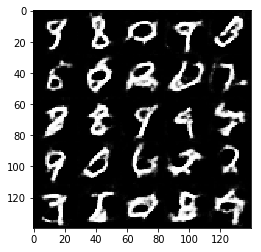

Epoch 2/2... Discriminator Loss: 1.2809... Generator Loss: 0.8536
Epoch 2/2... Discriminator Loss: 1.2325... Generator Loss: 0.9759
Epoch 2/2... Discriminator Loss: 1.2826... Generator Loss: 0.9852
Epoch 2/2... Discriminator Loss: 1.3269... Generator Loss: 0.7901
Epoch 2/2... Discriminator Loss: 1.3043... Generator Loss: 1.0694
Epoch 2/2... Discriminator Loss: 1.2412... Generator Loss: 0.8941
Epoch 2/2... Discriminator Loss: 1.3457... Generator Loss: 0.6421


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4064... Generator Loss: 10.4949
Epoch 1/1... Discriminator Loss: 0.4820... Generator Loss: 11.8804
Epoch 1/1... Discriminator Loss: 0.4424... Generator Loss: 3.4002
Epoch 1/1... Discriminator Loss: 0.5344... Generator Loss: 5.0100
Epoch 1/1... Discriminator Loss: 0.4370... Generator Loss: 3.3938
Epoch 1/1... Discriminator Loss: 0.5236... Generator Loss: 4.1106
Epoch 1/1... Discriminator Loss: 1.0065... Generator Loss: 0.9713
Epoch 1/1... Discriminator Loss: 0.8732... Generator Loss: 1.6631
Epoch 1/1... Discriminator Loss: 0.6451... Generator Loss: 1.9675
Epoch 1/1... Discriminator Loss: 0.8693... Generator Loss: 2.7205


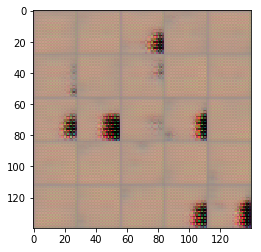

Epoch 1/1... Discriminator Loss: 1.1845... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 1.0054... Generator Loss: 1.0475
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.6307
Epoch 1/1... Discriminator Loss: 1.5055... Generator Loss: 0.4706
Epoch 1/1... Discriminator Loss: 1.1256... Generator Loss: 1.0226
Epoch 1/1... Discriminator Loss: 1.1227... Generator Loss: 1.6784
Epoch 1/1... Discriminator Loss: 1.5194... Generator Loss: 1.2745
Epoch 1/1... Discriminator Loss: 1.1243... Generator Loss: 1.1949
Epoch 1/1... Discriminator Loss: 0.8427... Generator Loss: 1.4606
Epoch 1/1... Discriminator Loss: 1.1814... Generator Loss: 0.9220


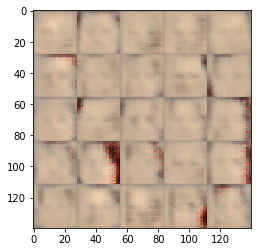

Epoch 1/1... Discriminator Loss: 0.9892... Generator Loss: 1.0199
Epoch 1/1... Discriminator Loss: 1.1172... Generator Loss: 1.0411
Epoch 1/1... Discriminator Loss: 1.1441... Generator Loss: 1.0965
Epoch 1/1... Discriminator Loss: 1.1196... Generator Loss: 1.1275
Epoch 1/1... Discriminator Loss: 1.1754... Generator Loss: 1.0498
Epoch 1/1... Discriminator Loss: 1.1366... Generator Loss: 0.9819
Epoch 1/1... Discriminator Loss: 0.9891... Generator Loss: 1.1348
Epoch 1/1... Discriminator Loss: 0.9027... Generator Loss: 1.2802
Epoch 1/1... Discriminator Loss: 0.8447... Generator Loss: 1.5573
Epoch 1/1... Discriminator Loss: 1.0310... Generator Loss: 0.9980


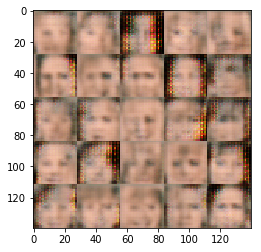

Epoch 1/1... Discriminator Loss: 0.9295... Generator Loss: 1.5627
Epoch 1/1... Discriminator Loss: 1.1868... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.0184... Generator Loss: 1.1447
Epoch 1/1... Discriminator Loss: 1.0350... Generator Loss: 0.8853
Epoch 1/1... Discriminator Loss: 1.1423... Generator Loss: 0.9880
Epoch 1/1... Discriminator Loss: 1.0942... Generator Loss: 1.2353
Epoch 1/1... Discriminator Loss: 1.0863... Generator Loss: 1.2425
Epoch 1/1... Discriminator Loss: 1.3231... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.1087... Generator Loss: 1.1067
Epoch 1/1... Discriminator Loss: 1.1924... Generator Loss: 0.8815


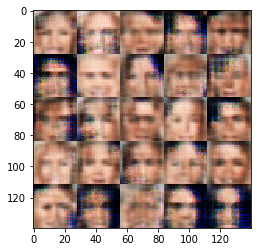

Epoch 1/1... Discriminator Loss: 1.2108... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.1089... Generator Loss: 0.8631
Epoch 1/1... Discriminator Loss: 1.1331... Generator Loss: 1.0731
Epoch 1/1... Discriminator Loss: 1.1757... Generator Loss: 1.0163
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 1.3789
Epoch 1/1... Discriminator Loss: 1.1991... Generator Loss: 1.0521
Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 0.8192
Epoch 1/1... Discriminator Loss: 1.1732... Generator Loss: 0.8519
Epoch 1/1... Discriminator Loss: 1.0868... Generator Loss: 1.0349


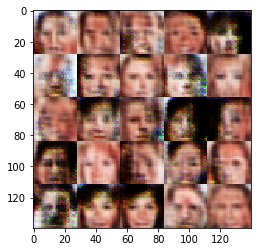

Epoch 1/1... Discriminator Loss: 1.9602... Generator Loss: 0.3693
Epoch 1/1... Discriminator Loss: 1.0910... Generator Loss: 0.9701
Epoch 1/1... Discriminator Loss: 1.2547... Generator Loss: 0.8323
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 1.0123
Epoch 1/1... Discriminator Loss: 1.1284... Generator Loss: 0.9739
Epoch 1/1... Discriminator Loss: 1.2727... Generator Loss: 0.8967
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.3076... Generator Loss: 0.8706
Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.6075
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 1.0302


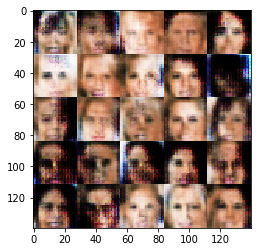

Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.6179
Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 0.8763
Epoch 1/1... Discriminator Loss: 1.3053... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 1.0210
Epoch 1/1... Discriminator Loss: 1.3249... Generator Loss: 0.8195
Epoch 1/1... Discriminator Loss: 1.1839... Generator Loss: 1.1524
Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 0.7860
Epoch 1/1... Discriminator Loss: 1.4475... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.1800... Generator Loss: 0.9319
Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 0.9957


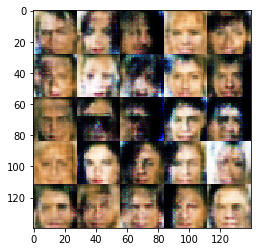

Epoch 1/1... Discriminator Loss: 1.1318... Generator Loss: 1.0502
Epoch 1/1... Discriminator Loss: 1.1927... Generator Loss: 0.8767
Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 0.9535
Epoch 1/1... Discriminator Loss: 1.0754... Generator Loss: 1.0691
Epoch 1/1... Discriminator Loss: 1.1199... Generator Loss: 1.0162
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 1.0898
Epoch 1/1... Discriminator Loss: 1.2227... Generator Loss: 1.0899
Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 0.9593
Epoch 1/1... Discriminator Loss: 1.0580... Generator Loss: 1.1120
Epoch 1/1... Discriminator Loss: 1.2979... Generator Loss: 0.9568


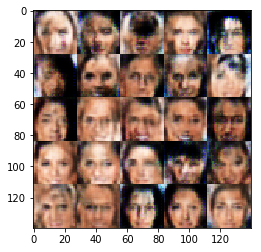

Epoch 1/1... Discriminator Loss: 1.2969... Generator Loss: 0.7735
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 1.3642
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.7253
Epoch 1/1... Discriminator Loss: 1.1729... Generator Loss: 0.8552
Epoch 1/1... Discriminator Loss: 1.1933... Generator Loss: 0.9003
Epoch 1/1... Discriminator Loss: 1.2793... Generator Loss: 0.7990
Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 0.8232
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.8206
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.5944
Epoch 1/1... Discriminator Loss: 1.2326... Generator Loss: 0.9163


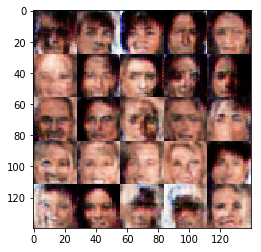

Epoch 1/1... Discriminator Loss: 1.1670... Generator Loss: 0.9098
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.6318... Generator Loss: 0.4716
Epoch 1/1... Discriminator Loss: 1.2260... Generator Loss: 1.0082
Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 0.6682
Epoch 1/1... Discriminator Loss: 1.2609... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.1754... Generator Loss: 1.1391
Epoch 1/1... Discriminator Loss: 1.1392... Generator Loss: 1.0318
Epoch 1/1... Discriminator Loss: 1.1164... Generator Loss: 1.0972
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.6229


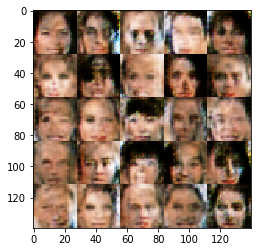

Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 0.8999
Epoch 1/1... Discriminator Loss: 1.2182... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.2768... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 1.3296... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 0.9010
Epoch 1/1... Discriminator Loss: 1.2079... Generator Loss: 0.9514
Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 1.2757... Generator Loss: 0.7033
Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 0.6954
Epoch 1/1... Discriminator Loss: 1.5141... Generator Loss: 1.3143


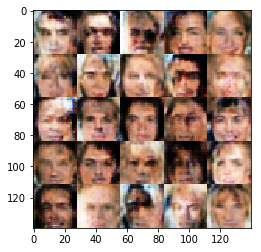

Epoch 1/1... Discriminator Loss: 1.1906... Generator Loss: 0.8516
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.6536
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.8382
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.8091
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.6773
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.2049... Generator Loss: 0.9628
Epoch 1/1... Discriminator Loss: 1.3024... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.8637


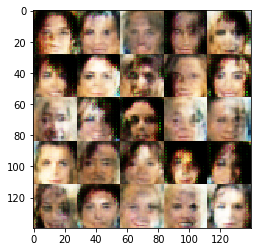

Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.7142
Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 0.7702
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.9378
Epoch 1/1... Discriminator Loss: 1.2471... Generator Loss: 0.8901
Epoch 1/1... Discriminator Loss: 1.3426... Generator Loss: 0.8349
Epoch 1/1... Discriminator Loss: 1.2587... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.9404
Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 1.0790
Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.8695


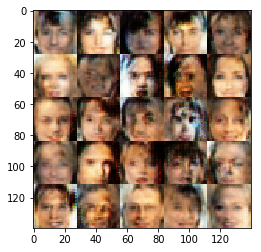

Epoch 1/1... Discriminator Loss: 1.2979... Generator Loss: 0.8195
Epoch 1/1... Discriminator Loss: 1.2453... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.2148... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.2001... Generator Loss: 1.0072
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.8471
Epoch 1/1... Discriminator Loss: 1.2025... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 0.8451
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.7489
Epoch 1/1... Discriminator Loss: 1.2419... Generator Loss: 0.7630


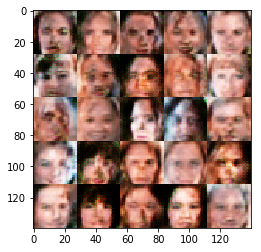

Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.8744
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.8618
Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.9122
Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 0.7086
Epoch 1/1... Discriminator Loss: 1.2286... Generator Loss: 0.9334
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.6289
Epoch 1/1... Discriminator Loss: 1.2754... Generator Loss: 0.8253
Epoch 1/1... Discriminator Loss: 1.2013... Generator Loss: 0.8627
Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.7069


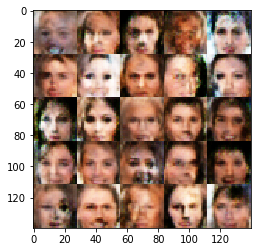

Epoch 1/1... Discriminator Loss: 1.2895... Generator Loss: 0.7197
Epoch 1/1... Discriminator Loss: 1.2412... Generator Loss: 0.7722
Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 0.8656
Epoch 1/1... Discriminator Loss: 1.1415... Generator Loss: 0.9650
Epoch 1/1... Discriminator Loss: 1.2985... Generator Loss: 0.8105
Epoch 1/1... Discriminator Loss: 1.3232... Generator Loss: 0.6318
Epoch 1/1... Discriminator Loss: 1.3362... Generator Loss: 0.8087
Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 0.9424
Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 0.7453


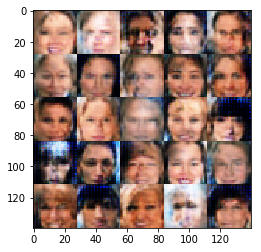

Epoch 1/1... Discriminator Loss: 1.2356... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.3045... Generator Loss: 0.8022
Epoch 1/1... Discriminator Loss: 1.1702... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 1.1826... Generator Loss: 0.9210
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 1.1581
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 1.1980
Epoch 1/1... Discriminator Loss: 1.2776... Generator Loss: 0.8793
Epoch 1/1... Discriminator Loss: 1.2320... Generator Loss: 0.9949
Epoch 1/1... Discriminator Loss: 1.2574... Generator Loss: 0.8555
Epoch 1/1... Discriminator Loss: 1.1231... Generator Loss: 0.9063


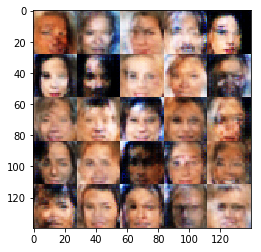

Epoch 1/1... Discriminator Loss: 1.2807... Generator Loss: 0.8289
Epoch 1/1... Discriminator Loss: 1.3122... Generator Loss: 0.6959
Epoch 1/1... Discriminator Loss: 1.1282... Generator Loss: 1.0229
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.5860
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.8983
Epoch 1/1... Discriminator Loss: 1.2749... Generator Loss: 0.8477
Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 0.8171
Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 0.9820
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 1.6743
Epoch 1/1... Discriminator Loss: 1.2634... Generator Loss: 0.8594


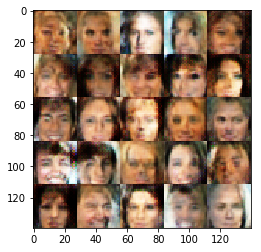

Epoch 1/1... Discriminator Loss: 1.2295... Generator Loss: 0.8282
Epoch 1/1... Discriminator Loss: 1.3225... Generator Loss: 0.8424
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.9248
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.5960
Epoch 1/1... Discriminator Loss: 1.1481... Generator Loss: 0.9806
Epoch 1/1... Discriminator Loss: 1.2073... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 1.2677... Generator Loss: 0.7812
Epoch 1/1... Discriminator Loss: 1.3386... Generator Loss: 0.7146
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 1.1441... Generator Loss: 0.9642


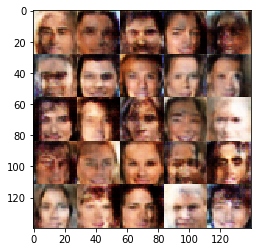

Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 1.1059
Epoch 1/1... Discriminator Loss: 1.2336... Generator Loss: 0.9313
Epoch 1/1... Discriminator Loss: 1.2951... Generator Loss: 0.7810
Epoch 1/1... Discriminator Loss: 1.2854... Generator Loss: 0.7416
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 1.0912... Generator Loss: 1.1276
Epoch 1/1... Discriminator Loss: 1.3303... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.2053... Generator Loss: 0.9338
Epoch 1/1... Discriminator Loss: 1.1562... Generator Loss: 0.9629
Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 0.9629


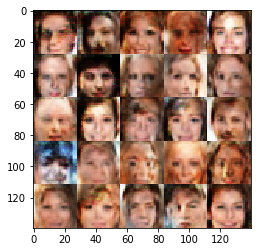

Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 0.8513
Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 1.1089
Epoch 1/1... Discriminator Loss: 1.2136... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 1.2427... Generator Loss: 0.8823
Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 1.2599... Generator Loss: 0.9489
Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.2343... Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 1.1216... Generator Loss: 0.9671


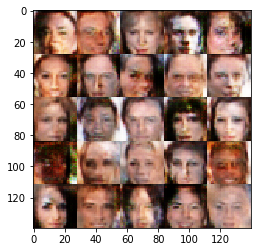

Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 1.2684
Epoch 1/1... Discriminator Loss: 1.1194... Generator Loss: 0.9216
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.8622
Epoch 1/1... Discriminator Loss: 1.1688... Generator Loss: 0.8821
Epoch 1/1... Discriminator Loss: 1.2185... Generator Loss: 0.9993
Epoch 1/1... Discriminator Loss: 1.2915... Generator Loss: 1.0571
Epoch 1/1... Discriminator Loss: 1.2032... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 1.2405... Generator Loss: 1.1050
Epoch 1/1... Discriminator Loss: 1.2016... Generator Loss: 0.8176


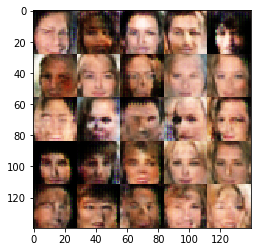

Epoch 1/1... Discriminator Loss: 1.3102... Generator Loss: 0.8372
Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 0.9773
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.8968
Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 1.0401
Epoch 1/1... Discriminator Loss: 1.2284... Generator Loss: 1.1427
Epoch 1/1... Discriminator Loss: 1.1870... Generator Loss: 0.9054
Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 0.9019
Epoch 1/1... Discriminator Loss: 1.2285... Generator Loss: 0.9177
Epoch 1/1... Discriminator Loss: 1.2124... Generator Loss: 1.0622
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 0.8982


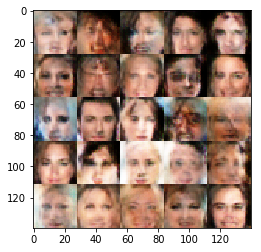

Epoch 1/1... Discriminator Loss: 1.2504... Generator Loss: 0.8423
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.6310
Epoch 1/1... Discriminator Loss: 1.2433... Generator Loss: 0.7458
Epoch 1/1... Discriminator Loss: 1.2129... Generator Loss: 0.8844
Epoch 1/1... Discriminator Loss: 1.2776... Generator Loss: 0.8091
Epoch 1/1... Discriminator Loss: 1.1559... Generator Loss: 0.9647
Epoch 1/1... Discriminator Loss: 1.1923... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 0.8742
Epoch 1/1... Discriminator Loss: 1.2700... Generator Loss: 0.7896
Epoch 1/1... Discriminator Loss: 1.2163... Generator Loss: 0.9517


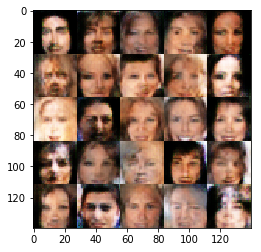

Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 0.8179
Epoch 1/1... Discriminator Loss: 1.2665... Generator Loss: 0.8976
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 0.7064
Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 1.1807... Generator Loss: 1.1031
Epoch 1/1... Discriminator Loss: 1.2399... Generator Loss: 1.0377
Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 0.7530
Epoch 1/1... Discriminator Loss: 1.2425... Generator Loss: 0.8678
Epoch 1/1... Discriminator Loss: 1.2890... Generator Loss: 0.7702
Epoch 1/1... Discriminator Loss: 1.1354... Generator Loss: 0.9676


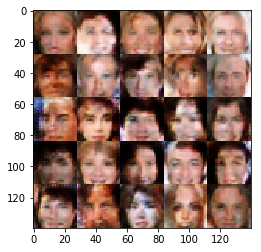

Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.7236
Epoch 1/1... Discriminator Loss: 1.2532... Generator Loss: 0.9951
Epoch 1/1... Discriminator Loss: 1.3229... Generator Loss: 0.8130
Epoch 1/1... Discriminator Loss: 1.1190... Generator Loss: 0.8587
Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.2381... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 1.2551... Generator Loss: 0.7257
Epoch 1/1... Discriminator Loss: 1.2927... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.1205... Generator Loss: 1.0525
Epoch 1/1... Discriminator Loss: 1.3252... Generator Loss: 0.6760


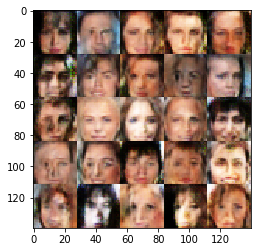

Epoch 1/1... Discriminator Loss: 1.2015... Generator Loss: 0.9852
Epoch 1/1... Discriminator Loss: 1.2025... Generator Loss: 0.9387
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.5345
Epoch 1/1... Discriminator Loss: 1.2581... Generator Loss: 1.0767
Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 0.9871
Epoch 1/1... Discriminator Loss: 1.1320... Generator Loss: 1.0430
Epoch 1/1... Discriminator Loss: 1.3593... Generator Loss: 0.6420
Epoch 1/1... Discriminator Loss: 1.2066... Generator Loss: 0.9396
Epoch 1/1... Discriminator Loss: 1.1986... Generator Loss: 0.7988


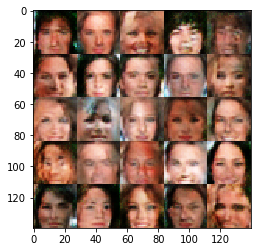

Epoch 1/1... Discriminator Loss: 1.1878... Generator Loss: 0.9067
Epoch 1/1... Discriminator Loss: 1.2018... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.2671... Generator Loss: 0.6247
Epoch 1/1... Discriminator Loss: 1.2531... Generator Loss: 0.9242
Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 0.8467
Epoch 1/1... Discriminator Loss: 1.2987... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.2180... Generator Loss: 0.8699
Epoch 1/1... Discriminator Loss: 1.1960... Generator Loss: 0.8561
Epoch 1/1... Discriminator Loss: 1.2103... Generator Loss: 0.8573
Epoch 1/1... Discriminator Loss: 1.1070... Generator Loss: 1.5096


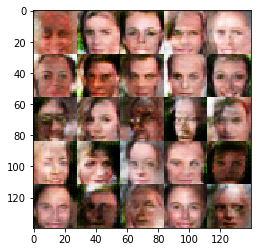

Epoch 1/1... Discriminator Loss: 1.1182... Generator Loss: 0.9295
Epoch 1/1... Discriminator Loss: 1.2434... Generator Loss: 0.8768
Epoch 1/1... Discriminator Loss: 1.1152... Generator Loss: 0.9994
Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 0.8617
Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 0.8774
Epoch 1/1... Discriminator Loss: 1.2388... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 1.1790... Generator Loss: 0.9330
Epoch 1/1... Discriminator Loss: 1.5101... Generator Loss: 0.5663
Epoch 1/1... Discriminator Loss: 1.1346... Generator Loss: 1.1243
Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 0.9746


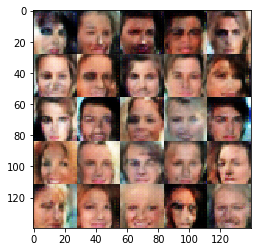

Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.1559... Generator Loss: 0.9085
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.6015
Epoch 1/1... Discriminator Loss: 1.2344... Generator Loss: 0.9224
Epoch 1/1... Discriminator Loss: 1.1995... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 1.2786... Generator Loss: 0.8790
Epoch 1/1... Discriminator Loss: 1.1237... Generator Loss: 0.8319
Epoch 1/1... Discriminator Loss: 1.1312... Generator Loss: 0.8533
Epoch 1/1... Discriminator Loss: 1.1023... Generator Loss: 1.0233


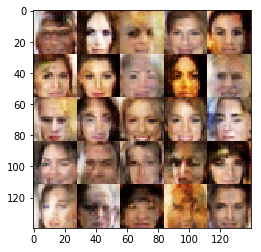

Epoch 1/1... Discriminator Loss: 1.2945... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 0.8272
Epoch 1/1... Discriminator Loss: 1.3258... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.2115... Generator Loss: 1.1472
Epoch 1/1... Discriminator Loss: 1.2288... Generator Loss: 0.9490
Epoch 1/1... Discriminator Loss: 1.3426... Generator Loss: 0.6809
Epoch 1/1... Discriminator Loss: 1.1079... Generator Loss: 1.4879
Epoch 1/1... Discriminator Loss: 1.2526... Generator Loss: 0.9213
Epoch 1/1... Discriminator Loss: 1.2574... Generator Loss: 0.8533
Epoch 1/1... Discriminator Loss: 1.3429... Generator Loss: 0.8193


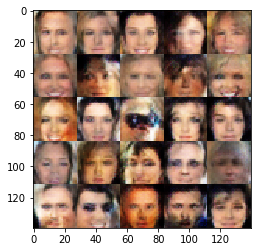

Epoch 1/1... Discriminator Loss: 1.1857... Generator Loss: 0.8642
Epoch 1/1... Discriminator Loss: 1.5454... Generator Loss: 1.8250
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 0.8460
Epoch 1/1... Discriminator Loss: 1.2113... Generator Loss: 0.8685
Epoch 1/1... Discriminator Loss: 1.0713... Generator Loss: 1.1351
Epoch 1/1... Discriminator Loss: 1.2626... Generator Loss: 0.9982
Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.2385... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.1462... Generator Loss: 1.1319


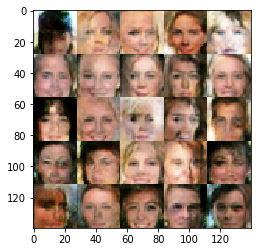

Epoch 1/1... Discriminator Loss: 1.2378... Generator Loss: 0.8488
Epoch 1/1... Discriminator Loss: 1.1365... Generator Loss: 0.9770
Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.6141
Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.8547
Epoch 1/1... Discriminator Loss: 1.2444... Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 1.3014... Generator Loss: 0.6624
Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 0.6552
Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 0.8378
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.7357


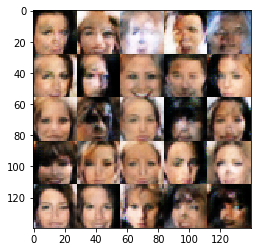

Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 0.8193
Epoch 1/1... Discriminator Loss: 1.2115... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.7894
Epoch 1/1... Discriminator Loss: 1.1222... Generator Loss: 0.9644
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 1.0536
Epoch 1/1... Discriminator Loss: 1.1773... Generator Loss: 0.8549
Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 0.9402


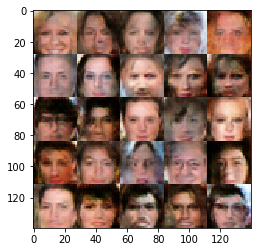

Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.7309
Epoch 1/1... Discriminator Loss: 1.2334... Generator Loss: 1.1313
Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 1.1021
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.5561
Epoch 1/1... Discriminator Loss: 1.0567... Generator Loss: 1.1297
Epoch 1/1... Discriminator Loss: 1.2191... Generator Loss: 0.9188
Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 0.8193
Epoch 1/1... Discriminator Loss: 1.3002... Generator Loss: 1.0045
Epoch 1/1... Discriminator Loss: 1.1612... Generator Loss: 0.9695
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 0.9724


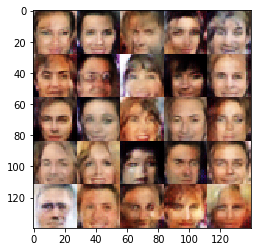

Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 0.9820
Epoch 1/1... Discriminator Loss: 1.2585... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 1.2543
Epoch 1/1... Discriminator Loss: 1.2458... Generator Loss: 0.7040
Epoch 1/1... Discriminator Loss: 1.1582... Generator Loss: 0.8960
Epoch 1/1... Discriminator Loss: 1.1714... Generator Loss: 0.9088
Epoch 1/1... Discriminator Loss: 1.1708... Generator Loss: 0.8822
Epoch 1/1... Discriminator Loss: 1.2788... Generator Loss: 0.7437
Epoch 1/1... Discriminator Loss: 1.1871... Generator Loss: 0.7555
Epoch 1/1... Discriminator Loss: 1.2331... Generator Loss: 0.8715


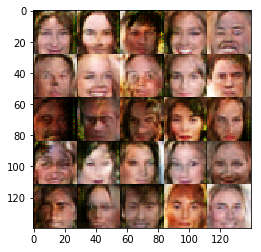

Epoch 1/1... Discriminator Loss: 1.2708... Generator Loss: 0.7515
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.9344
Epoch 1/1... Discriminator Loss: 1.2529... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 1.2312... Generator Loss: 0.8630
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 0.9498
Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 0.9974
Epoch 1/1... Discriminator Loss: 1.1693... Generator Loss: 0.9059
Epoch 1/1... Discriminator Loss: 1.2503... Generator Loss: 0.7995
Epoch 1/1... Discriminator Loss: 1.1986... Generator Loss: 1.2462
Epoch 1/1... Discriminator Loss: 1.1651... Generator Loss: 0.8595


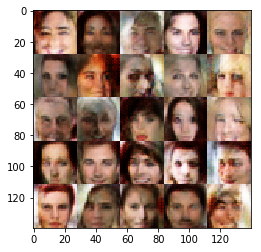

Epoch 1/1... Discriminator Loss: 1.2059... Generator Loss: 0.9933
Epoch 1/1... Discriminator Loss: 1.2175... Generator Loss: 1.3100
Epoch 1/1... Discriminator Loss: 1.2288... Generator Loss: 0.8012
Epoch 1/1... Discriminator Loss: 1.2546... Generator Loss: 0.8556
Epoch 1/1... Discriminator Loss: 1.2439... Generator Loss: 0.9505
Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 1.1754... Generator Loss: 1.1029
Epoch 1/1... Discriminator Loss: 1.0883... Generator Loss: 1.2572
Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 1.0875
Epoch 1/1... Discriminator Loss: 1.2051... Generator Loss: 0.8235


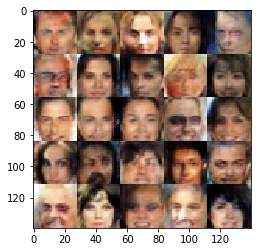

Epoch 1/1... Discriminator Loss: 1.1737... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.2184... Generator Loss: 0.9911
Epoch 1/1... Discriminator Loss: 1.3192... Generator Loss: 0.8099
Epoch 1/1... Discriminator Loss: 1.2707... Generator Loss: 0.9345
Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 0.8437
Epoch 1/1... Discriminator Loss: 1.3154... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.9034
Epoch 1/1... Discriminator Loss: 1.3083... Generator Loss: 1.3483
Epoch 1/1... Discriminator Loss: 1.2754... Generator Loss: 0.9846
Epoch 1/1... Discriminator Loss: 1.2503... Generator Loss: 1.0604


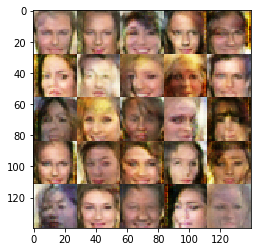

Epoch 1/1... Discriminator Loss: 1.2255... Generator Loss: 0.9061
Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 0.9969
Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 1.1990
Epoch 1/1... Discriminator Loss: 1.2124... Generator Loss: 0.8471
Epoch 1/1... Discriminator Loss: 1.2627... Generator Loss: 0.8086
Epoch 1/1... Discriminator Loss: 1.2084... Generator Loss: 0.9684
Epoch 1/1... Discriminator Loss: 1.2942... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.2050... Generator Loss: 1.0706
Epoch 1/1... Discriminator Loss: 1.3008... Generator Loss: 0.9539
Epoch 1/1... Discriminator Loss: 1.1949... Generator Loss: 0.8579


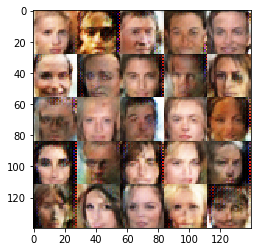

Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 1.2402
Epoch 1/1... Discriminator Loss: 1.4475... Generator Loss: 0.6100
Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 0.8349
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 1.1570... Generator Loss: 1.1047
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 0.8532
Epoch 1/1... Discriminator Loss: 1.2183... Generator Loss: 0.9185
Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 0.8426
Epoch 1/1... Discriminator Loss: 1.2521... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 1.1583... Generator Loss: 0.7958


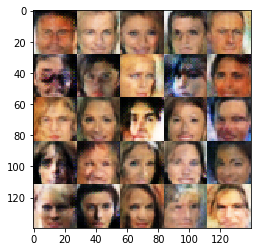

Epoch 1/1... Discriminator Loss: 1.2446... Generator Loss: 0.9698
Epoch 1/1... Discriminator Loss: 1.2784... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 1.1941... Generator Loss: 0.9493
Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.7248
Epoch 1/1... Discriminator Loss: 1.1558... Generator Loss: 0.8602
Epoch 1/1... Discriminator Loss: 1.2522... Generator Loss: 0.8919
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 0.7328
Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 1.1787... Generator Loss: 0.8942


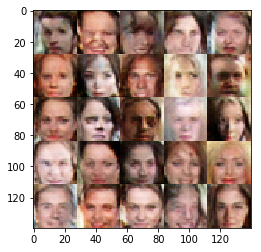

Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 0.8031
Epoch 1/1... Discriminator Loss: 1.1940... Generator Loss: 0.8511
Epoch 1/1... Discriminator Loss: 1.3515... Generator Loss: 0.7502
Epoch 1/1... Discriminator Loss: 1.1422... Generator Loss: 0.9400
Epoch 1/1... Discriminator Loss: 1.2868... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 0.8661
Epoch 1/1... Discriminator Loss: 1.2262... Generator Loss: 0.9200
Epoch 1/1... Discriminator Loss: 1.2512... Generator Loss: 0.9000
Epoch 1/1... Discriminator Loss: 1.1805... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.7843


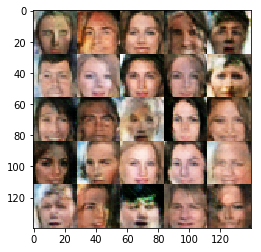

Epoch 1/1... Discriminator Loss: 1.1455... Generator Loss: 0.9137
Epoch 1/1... Discriminator Loss: 1.2654... Generator Loss: 0.9001
Epoch 1/1... Discriminator Loss: 1.2214... Generator Loss: 0.8561
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.9250
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.8596
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 1.0260
Epoch 1/1... Discriminator Loss: 1.2001... Generator Loss: 0.8744
Epoch 1/1... Discriminator Loss: 1.2094... Generator Loss: 1.0873
Epoch 1/1... Discriminator Loss: 1.1823... Generator Loss: 0.8503


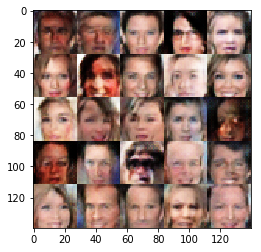

Epoch 1/1... Discriminator Loss: 1.2697... Generator Loss: 0.9446
Epoch 1/1... Discriminator Loss: 1.2243... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 1.0759
Epoch 1/1... Discriminator Loss: 1.1766... Generator Loss: 0.8204
Epoch 1/1... Discriminator Loss: 1.2221... Generator Loss: 0.8111
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.6534
Epoch 1/1... Discriminator Loss: 1.1879... Generator Loss: 1.2141
Epoch 1/1... Discriminator Loss: 1.2633... Generator Loss: 0.7131
Epoch 1/1... Discriminator Loss: 1.2794... Generator Loss: 0.7627
Epoch 1/1... Discriminator Loss: 1.2288... Generator Loss: 0.8848


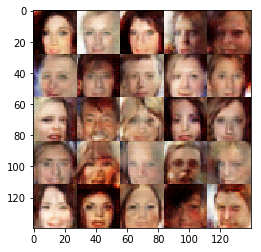

Epoch 1/1... Discriminator Loss: 1.1893... Generator Loss: 0.9793
Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 0.8396
Epoch 1/1... Discriminator Loss: 1.2240... Generator Loss: 1.0590
Epoch 1/1... Discriminator Loss: 1.2661... Generator Loss: 0.8670
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.8312
Epoch 1/1... Discriminator Loss: 1.1824... Generator Loss: 0.9149
Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 0.9862
Epoch 1/1... Discriminator Loss: 1.2259... Generator Loss: 0.9240
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 1.2434
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.8123


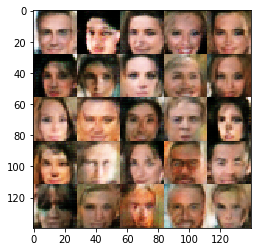

Epoch 1/1... Discriminator Loss: 1.1995... Generator Loss: 0.9291
Epoch 1/1... Discriminator Loss: 1.2202... Generator Loss: 0.9222
Epoch 1/1... Discriminator Loss: 1.2220... Generator Loss: 0.8196
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.8717
Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.8734
Epoch 1/1... Discriminator Loss: 1.2524... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 1.1962... Generator Loss: 0.8465
Epoch 1/1... Discriminator Loss: 1.2846... Generator Loss: 0.8322
Epoch 1/1... Discriminator Loss: 1.2544... Generator Loss: 0.9199
Epoch 1/1... Discriminator Loss: 1.1918... Generator Loss: 0.8121


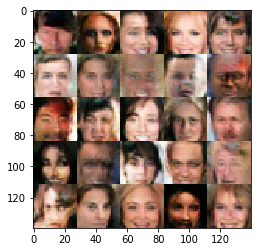

Epoch 1/1... Discriminator Loss: 1.2566... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.9538
Epoch 1/1... Discriminator Loss: 1.1753... Generator Loss: 0.9443
Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.2106... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 0.8224
Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 0.8734
Epoch 1/1... Discriminator Loss: 1.2806... Generator Loss: 0.8278
Epoch 1/1... Discriminator Loss: 1.1904... Generator Loss: 0.9306
Epoch 1/1... Discriminator Loss: 1.2770... Generator Loss: 0.8543


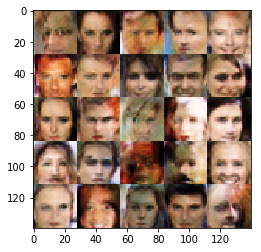

Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.6390
Epoch 1/1... Discriminator Loss: 1.2749... Generator Loss: 0.8706
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.6028
Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 0.8186
Epoch 1/1... Discriminator Loss: 1.1689... Generator Loss: 1.0220
Epoch 1/1... Discriminator Loss: 1.2699... Generator Loss: 0.8252
Epoch 1/1... Discriminator Loss: 1.2812... Generator Loss: 0.7658
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.6277
Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.7830
Epoch 1/1... Discriminator Loss: 1.2626... Generator Loss: 0.9805


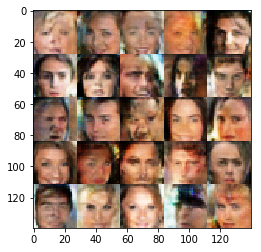

Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.5070
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.6866
Epoch 1/1... Discriminator Loss: 1.2143... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 1.2565... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 1.2175... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 1.2077... Generator Loss: 1.0568
Epoch 1/1... Discriminator Loss: 1.2399... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.1109... Generator Loss: 0.8787
Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 0.6749
Epoch 1/1... Discriminator Loss: 1.1924... Generator Loss: 0.8707


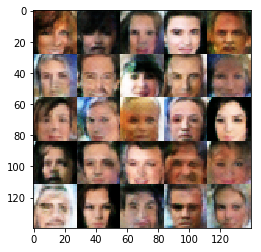

Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 1.0042
Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 0.9623
Epoch 1/1... Discriminator Loss: 1.2849... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.8082
Epoch 1/1... Discriminator Loss: 1.2523... Generator Loss: 0.8660
Epoch 1/1... Discriminator Loss: 1.2783... Generator Loss: 0.9210
Epoch 1/1... Discriminator Loss: 1.1905... Generator Loss: 0.9612
Epoch 1/1... Discriminator Loss: 1.1582... Generator Loss: 0.9377
Epoch 1/1... Discriminator Loss: 1.2573... Generator Loss: 0.9539
Epoch 1/1... Discriminator Loss: 1.2603... Generator Loss: 0.7410


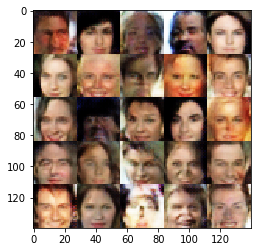

Epoch 1/1... Discriminator Loss: 1.1855... Generator Loss: 0.8812
Epoch 1/1... Discriminator Loss: 1.1688... Generator Loss: 0.9496
Epoch 1/1... Discriminator Loss: 1.1915... Generator Loss: 0.9185
Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 0.8472
Epoch 1/1... Discriminator Loss: 1.1171... Generator Loss: 0.9079
Epoch 1/1... Discriminator Loss: 1.1886... Generator Loss: 1.0467
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 0.9358
Epoch 1/1... Discriminator Loss: 1.3083... Generator Loss: 0.8943
Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 0.9473
Epoch 1/1... Discriminator Loss: 1.2037... Generator Loss: 0.9429


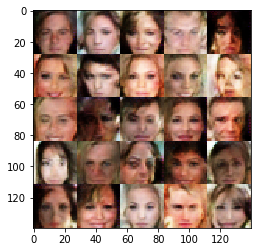

Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 0.8181
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.6688
Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 1.2468
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 0.7119
Epoch 1/1... Discriminator Loss: 1.2498... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.2950... Generator Loss: 0.9900
Epoch 1/1... Discriminator Loss: 1.2784... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.2689... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 1.3014... Generator Loss: 1.2192
Epoch 1/1... Discriminator Loss: 1.2311... Generator Loss: 0.9303


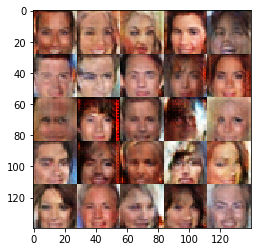

Epoch 1/1... Discriminator Loss: 1.2446... Generator Loss: 0.9060
Epoch 1/1... Discriminator Loss: 1.2087... Generator Loss: 1.0402
Epoch 1/1... Discriminator Loss: 1.1547... Generator Loss: 0.8875
Epoch 1/1... Discriminator Loss: 1.1776... Generator Loss: 1.0838
Epoch 1/1... Discriminator Loss: 1.3207... Generator Loss: 0.6761
Epoch 1/1... Discriminator Loss: 1.2853... Generator Loss: 0.6836
Epoch 1/1... Discriminator Loss: 1.3515... Generator Loss: 1.3504
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.8536
Epoch 1/1... Discriminator Loss: 1.2170... Generator Loss: 1.2545
Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 0.6442


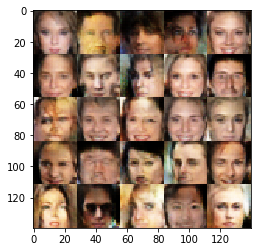

Epoch 1/1... Discriminator Loss: 1.1484... Generator Loss: 0.9509
Epoch 1/1... Discriminator Loss: 1.1800... Generator Loss: 0.8334
Epoch 1/1... Discriminator Loss: 1.2532... Generator Loss: 0.8123
Epoch 1/1... Discriminator Loss: 1.2562... Generator Loss: 0.8832
Epoch 1/1... Discriminator Loss: 1.3294... Generator Loss: 1.1330
Epoch 1/1... Discriminator Loss: 1.2476... Generator Loss: 1.0356
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.9092
Epoch 1/1... Discriminator Loss: 1.2923... Generator Loss: 0.7484
Epoch 1/1... Discriminator Loss: 1.2990... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 1.2884... Generator Loss: 1.0062


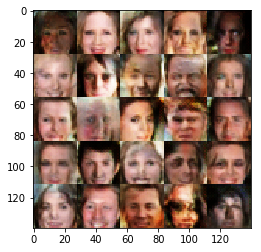

Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 0.9601
Epoch 1/1... Discriminator Loss: 1.3152... Generator Loss: 0.9158
Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.7914
Epoch 1/1... Discriminator Loss: 1.2910... Generator Loss: 0.9180
Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 1.4075
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.2567... Generator Loss: 0.9425
Epoch 1/1... Discriminator Loss: 1.2521... Generator Loss: 0.9306
Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.7440


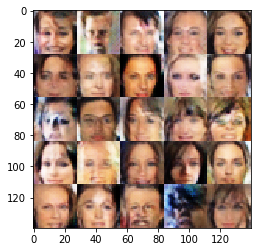

Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 0.7960
Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 0.9047
Epoch 1/1... Discriminator Loss: 1.1775... Generator Loss: 0.9808
Epoch 1/1... Discriminator Loss: 1.2566... Generator Loss: 0.8908
Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 1.2431... Generator Loss: 0.8384
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.6902
Epoch 1/1... Discriminator Loss: 1.2854... Generator Loss: 0.8821
Epoch 1/1... Discriminator Loss: 1.2939... Generator Loss: 0.8543
Epoch 1/1... Discriminator Loss: 1.1582... Generator Loss: 0.8525


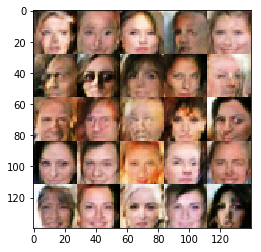

Epoch 1/1... Discriminator Loss: 1.1628... Generator Loss: 1.2254
Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 0.6428
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 1.4852
Epoch 1/1... Discriminator Loss: 1.2496... Generator Loss: 1.0688
Epoch 1/1... Discriminator Loss: 1.1884... Generator Loss: 0.9569
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.8542
Epoch 1/1... Discriminator Loss: 1.1767... Generator Loss: 0.8787
Epoch 1/1... Discriminator Loss: 1.1319... Generator Loss: 1.0821
Epoch 1/1... Discriminator Loss: 1.2253... Generator Loss: 0.8583
Epoch 1/1... Discriminator Loss: 1.2439... Generator Loss: 0.8961


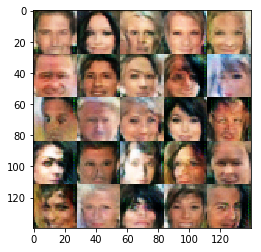

Epoch 1/1... Discriminator Loss: 1.1553... Generator Loss: 0.9297
Epoch 1/1... Discriminator Loss: 1.2141... Generator Loss: 1.0419
Epoch 1/1... Discriminator Loss: 1.3251... Generator Loss: 1.0034
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 1.1320
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 1.0076
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.6518
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.1564... Generator Loss: 0.9261
Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 0.8372
Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 0.7538


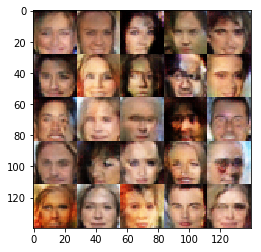

Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 0.8552
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.7448
Epoch 1/1... Discriminator Loss: 1.3087... Generator Loss: 0.8636
Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 0.6708
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.5791
Epoch 1/1... Discriminator Loss: 1.1880... Generator Loss: 0.8191
Epoch 1/1... Discriminator Loss: 1.1674... Generator Loss: 1.0838
Epoch 1/1... Discriminator Loss: 1.2109... Generator Loss: 0.8623
Epoch 1/1... Discriminator Loss: 1.1559... Generator Loss: 0.9272


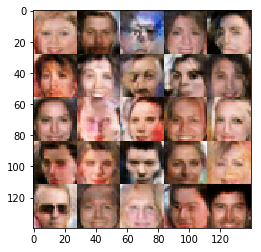

Epoch 1/1... Discriminator Loss: 1.2909... Generator Loss: 0.9648
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.5869
Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 0.8359
Epoch 1/1... Discriminator Loss: 1.2580... Generator Loss: 0.9373
Epoch 1/1... Discriminator Loss: 1.2158... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 1.0324
Epoch 1/1... Discriminator Loss: 1.3519... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 1.1537... Generator Loss: 1.2239
Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.2350... Generator Loss: 0.6799


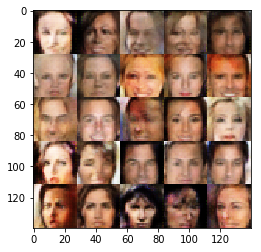

Epoch 1/1... Discriminator Loss: 1.2658... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 0.8862
Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.1123... Generator Loss: 0.9388
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.6844
Epoch 1/1... Discriminator Loss: 1.2175... Generator Loss: 1.1297
Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 1.0168
Epoch 1/1... Discriminator Loss: 1.2067... Generator Loss: 1.0699
Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 1.0259
Epoch 1/1... Discriminator Loss: 1.1641... Generator Loss: 0.9634


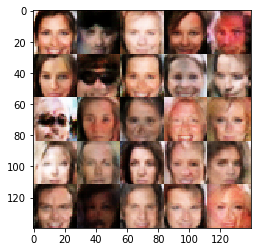

Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.9015
Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 0.8844
Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 0.8400
Epoch 1/1... Discriminator Loss: 1.2276... Generator Loss: 0.9053
Epoch 1/1... Discriminator Loss: 1.2361... Generator Loss: 0.7274
Epoch 1/1... Discriminator Loss: 1.1958... Generator Loss: 0.9281
Epoch 1/1... Discriminator Loss: 1.2592... Generator Loss: 1.0358
Epoch 1/1... Discriminator Loss: 1.2940... Generator Loss: 0.8135
Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 0.7506
Epoch 1/1... Discriminator Loss: 1.2328... Generator Loss: 0.8329


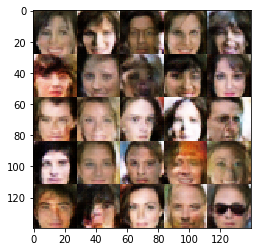

Epoch 1/1... Discriminator Loss: 1.2605... Generator Loss: 0.8132
Epoch 1/1... Discriminator Loss: 1.2419... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 1.4131


In [16]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.